<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Выборки-с-TF-IDF" data-toc-modified-id="Выборки-с-TF-IDF-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Выборки с TF-IDF</a></span></li><li><span><a href="#Выборки-с-эмбеддингами" data-toc-modified-id="Выборки-с-эмбеддингами-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Выборки с эмбеддингами</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модели-с-TF-IDF" data-toc-modified-id="Модели-с-TF-IDF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модели с TF-IDF</a></span></li><li><span><a href="#Модели-с-эмбеддингами" data-toc-modified-id="Модели-с-эмбеддингами-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модели с эмбеддингами</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Определение токсичных комментариев

Интернет-магазин запускает новый сервис: теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Значение метрики качества *F1* должно быть не меньше 0.75. 

## Подготовка

### Обзор данных

Импортируем библиотеки:

In [1]:
!pip install -U spacy[cuda112]
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80.8 MB 98 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 11.7 MB/s 
     |████████████████████████████████| 182 kB 53.8 MB/s 
     |████████████████████████████████| 7.6 MB 10.1 MB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from nltk.corpus import stopwords 
import nltk
import torch
import transformers
from tqdm import notebook, tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
pd.options.mode.chained_assignment = None

In [3]:
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
gpu = spacy.prefer_gpu()
print('GPU:', gpu)

cuda
GPU: True


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
df = pd.read_csv('/content/gdrive/My Drive/toxic_comments.csv', index_col=0)

Посмотим на данные:

In [6]:
def total_view(df: pd.DataFrame, n_rows=5, seed=None):
    '''Возвращает первые, случайные и последние строки таблицы (по умолчанию по 5 строк)'''
    return display(pd.concat([
                              df.head(n_rows),
                              df.sample(n_rows, random_state=seed),
                              df.tail(n_rows)
                             ]))

total_view(df)
df.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
48178,"""\n\n Politics section edit \n\nI removed the ...",0
142717,'quantum mechanics is not a superset of quantu...,0
131824,many of prdue's astronauts might have been,0
121729,I said no such thing. You are twisting my comm...,0
34336,(UTC)\n\nFunding is not addressed specifically...,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [7]:
df['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

**Выводы:**
- В датасете 2 колонки и 159292 строк. В колонке `text` содержатся тексты комментариев, в `toxic` - целевой признак;
- классы не сбалансированы, соотношение токсичных комментариев к нетоксичным примерно 1 к 9;
- комментарии содержат текст на английском языке, знаки пунктуации и переноса строк и другие символы.

### Предобработка данных

Уберем все знаки пунктуации и лишние пробелы, проведем лемматизацию:

In [8]:
en = spacy.load('en_core_web_sm')

def text_editing(row):
    "Возвращает отредактированный текст"
    t = re.sub(r'[^a-zA-Z]', ' ', row).split()
    t = ' '.join(t)
    t = [token.lemma_ for token in en(t)]
    t = ' '.join(t)
    return t.lower()

tqdm.pandas()
df['text'] = df['text'].progress_apply(text_editing)
total_view(df)

100%|██████████| 159292/159292 [36:59<00:00, 71.76it/s]


,text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0
98108,neiln s constant agenda drive edit non neutral...,0
70254,please contribute to improve wikipedia hi user...,0
34368,glad to help out,0
108881,ms marsden be a highly controversial political...,0
142655,please stop your disruptive editing if your va...,0


Удалим дубликаты:

In [9]:
df.duplicated().sum()

1308

In [10]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Разделим датасет на обучающую и тестовую выборки:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[['text']],
                                                    df['toxic'],
                                                    random_state=SEED,
                                                    stratify=df['toxic'],
                                                    test_size=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(126387, 1)
(126387,)
(31597, 1)
(31597,)


#### Выборки с TF-IDF

Создадим объект класса TfidfVectorizer для дальнейшего использования в пайплайне.

In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Выборки с эмбеддингами

Посмотрим на распределение длины комментариев в обучающей выборке:

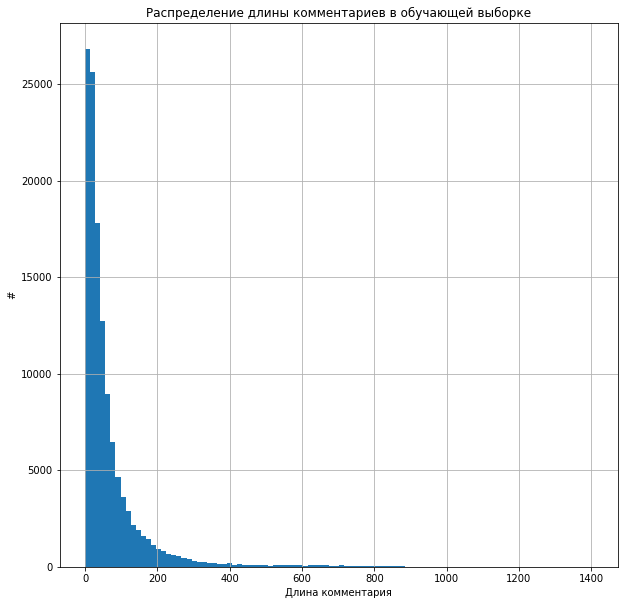

In [13]:
tmp = X_train.copy()
tmp['len_text'] = [len(x.split()) for x in tmp['text']]

plt.figure(figsize=(10, 10))
plt.xlabel('Длина комментария')
plt.ylabel('#')
plt.title('Распределение длины комментариев в обучающей выборке')
tmp['len_text'].hist(bins=100)
None

In [14]:
print('Комментариев короче 100 слов:', 
      round((tmp.loc[tmp['len_text'] < 100, 'text'].count() / len(tmp)) * 100 , 2),
      '%')

Комментариев короче 100 слов: 81.84 %


Большинство комментариев - короткие. Напишем функцию с использованием BERT для получения эмбеддингов, количество токенов укажем равным 100.

In [15]:
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert').to(DEVICE)
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

def make_embeddings(df, tokenizer, model, batch_size=512, max_length=100):
    """Возвращает эмбеддинги"""
    tokenized = df['text'].apply(lambda x: tokenizer.encode(x,
                                                            add_special_tokens=True,
                                                            truncation=True,
                                                            max_length = max_length,
                                                            padding='max_length'
                                                           )
                                )
    padded = np.array([i for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(DEVICE) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(DEVICE)
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
            embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        if i == (padded.shape[0] // batch_size - 1):
            batch = torch.LongTensor(padded[batch_size*(i+1):]).to(DEVICE) 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*(i+1):]).to(DEVICE)
            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)
                embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
                
    return np.concatenate(embeddings)

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [16]:
X_train_emb = make_embeddings(X_train, tokenizer, model, 512, 100)
X_train_emb.shape

  0%|          | 0/246 [00:00<?, ?it/s]

(126387, 768)

In [17]:
X_test_emb = make_embeddings(X_test, tokenizer, model, 512, 100)
X_test_emb.shape

  0%|          | 0/61 [00:00<?, ?it/s]

(31597, 768)

**Выводы:**
- проведена предобработка текста - удалены знаки пунктуации, проведена лемматизация, удалены дубликаты;
- подготовлены выборки с TF-IDF и с эмбеддингами.

## Обучение

### Модели с TF-IDF

In [18]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)

pipeline = Pipeline([('tfidf', count_tf_idf),
                     ('lr', lr),
                    ]
                   )
param_grid = {'lr__C': [0.1, 10]}
grid_lr = GridSearchCV(pipeline,
                       param_grid=param_grid,
                       cv=5,
                       scoring='f1',
                       verbose=3,
                       n_jobs=-1)
grid_lr.fit(X_train['text'], y_train)

print(f'F1: {round(grid_lr.best_score_, 4)}',
      'Наилучшие параметры:',
      f'C: {grid_lr.best_params_["lr__C"]}',
      sep='\n')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
F1: 0.7622
Наилучшие параметры:
C: 10


Логистическая регрессия с TF-IDF достигла метрики F1 0.76 при кросс-валидации с параметром C=10.

In [19]:
model_dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
pipeline = Pipeline([('tfidf', count_tf_idf),
                     ('dt', model_dt),
                    ]
                   )
param_grid = {'dt__max_depth': [8, 20]}
grid_dt = GridSearchCV(pipeline,
                       param_grid=param_grid,
                       cv=5,
                       scoring='f1',
                       verbose=3,
                       n_jobs=-1)
grid_dt.fit(X_train['text'], y_train)

print(f'F1: {round(grid_dt.best_score_, 4)}',
      'Наилучшие параметры:',
      f'C: {grid_dt.best_params_["dt__max_depth"]}',
      sep='\n')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
F1: 0.6323
Наилучшие параметры:
C: 20


Модель DecisionTreeClassifier с TF-IDF достигла метрики F1 0.63 при кросс-валидации с глубиной 20.

In [21]:
model_lgbm = LGBMClassifier(random_state=42, metric='auc', class_weight='balanced')
pipeline = Pipeline([('tfidf', count_tf_idf),
                     ('lgbm', model_lgbm),
                    ]
                   )
param_grid = {'lgbm__max_depth': [8, 9],
              'lgbm__n_estimators': [200, 350]
             }
grid_lgbm = GridSearchCV(pipeline,
                         param_grid=param_grid,
                         cv=5,
                         scoring='f1',
                         verbose=3)
grid_lgbm.fit(X_train['text'], y_train)

print(f'F1: {round(grid_lgbm.best_score_, 4)}',
      'Наилучшие параметры:',
      f'max_depth: {grid_lgbm.best_params_["lgbm__max_depth"]}',
      f'n_estimators: {grid_lgbm.best_params_["lgbm__n_estimators"]}',
      sep='\n')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END lgbm__max_depth=8, lgbm__n_estimators=200;, score=0.745 total time=  49.8s
[CV 2/5] END lgbm__max_depth=8, lgbm__n_estimators=200;, score=0.745 total time=  51.9s
[CV 3/5] END lgbm__max_depth=8, lgbm__n_estimators=200;, score=0.745 total time= 1.1min
[CV 4/5] END lgbm__max_depth=8, lgbm__n_estimators=200;, score=0.750 total time=  51.6s
[CV 5/5] END lgbm__max_depth=8, lgbm__n_estimators=200;, score=0.742 total time=  49.2s
[CV 1/5] END lgbm__max_depth=8, lgbm__n_estimators=350;, score=0.756 total time= 1.3min
[CV 2/5] END lgbm__max_depth=8, lgbm__n_estimators=350;, score=0.758 total time= 1.3min
[CV 3/5] END lgbm__max_depth=8, lgbm__n_estimators=350;, score=0.761 total time= 1.3min
[CV 4/5] END lgbm__max_depth=8, lgbm__n_estimators=350;, score=0.755 total time= 1.3min
[CV 5/5] END lgbm__max_depth=8, lgbm__n_estimators=350;, score=0.754 total time= 1.3min
[CV 1/5] END lgbm__max_depth=9, lgbm__n_estimators=200;, sco

Модель LGBMClassifier с TF-IDF достигла метрики F1 0.76 при кросс-валидации с количеством оценщиков 350 и глубиной 9.

### Модели с эмбеддингами

In [22]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
param_grid = {'C': [0.1, 1]}
grid_lr_emb = GridSearchCV(lr,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1',
                           verbose=3,
                           n_jobs=-1)
grid_lr_emb.fit(X_train_emb, y_train)

print(f'F1: {round(grid_lr_emb.best_score_, 4)}',
      'Наилучшие параметры:',
      f'C: {grid_lr_emb.best_params_["C"]}',
      sep='\n')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
F1: 0.8529
Наилучшие параметры:
C: 0.1


Логистическая регрессия с эмбеддингами достигла метрики F1 0.85 при кросс-валидации с параметром C=0.1.

In [23]:
model_dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
param_grid = {'max_depth': [6, 8]}
grid_dt_emb = GridSearchCV(model_dt,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1',
                           verbose=3,
                           n_jobs=-1)
grid_dt_emb.fit(X_train_emb, y_train)

print(f'F1: {round(grid_dt_emb.best_score_, 4)}',
      'Наилучшие параметры:',
      f'C: {grid_dt_emb.best_params_["max_depth"]}',
      sep='\n')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
F1: 0.8375
Наилучшие параметры:
C: 6


Модель DecisionTreeClassifier с эмбеддингами достигла метрики F1 0.84 при кросс-валидации с глубиной 6.

In [24]:
model_lgbm = LGBMClassifier(random_state=42, metric='auc', class_weight='balanced')
param_grid = {'max_depth': [6, 9],
              'n_estimators': [150, 350]
              }
grid_lgbm_emb = GridSearchCV(model_lgbm,
                             param_grid=param_grid,
                             cv=5,
                             scoring='f1',
                             verbose=3)
grid_lgbm_emb.fit(X_train_emb, y_train)

print(f'F1: {round(grid_lgbm_emb.best_score_, 4)}',
      'Наилучшие параметры:',
      f'max_depth: {grid_lgbm_emb.best_params_["max_depth"]}',
      f'n_estimators: {grid_lgbm_emb.best_params_["n_estimators"]}',
      sep='\n')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....max_depth=6, n_estimators=150;, score=0.872 total time= 1.4min
[CV 2/5] END .....max_depth=6, n_estimators=150;, score=0.873 total time= 1.4min
[CV 3/5] END .....max_depth=6, n_estimators=150;, score=0.885 total time= 1.3min
[CV 4/5] END .....max_depth=6, n_estimators=150;, score=0.879 total time= 1.4min
[CV 5/5] END .....max_depth=6, n_estimators=150;, score=0.875 total time= 1.3min
[CV 1/5] END .....max_depth=6, n_estimators=350;, score=0.885 total time= 2.6min
[CV 2/5] END .....max_depth=6, n_estimators=350;, score=0.888 total time= 2.6min
[CV 3/5] END .....max_depth=6, n_estimators=350;, score=0.900 total time= 2.5min
[CV 4/5] END .....max_depth=6, n_estimators=350;, score=0.888 total time= 2.6min
[CV 5/5] END .....max_depth=6, n_estimators=350;, score=0.890 total time= 2.6min
[CV 1/5] END .....max_depth=9, n_estimators=150;, score=0.876 total time= 1.5min
[CV 2/5] END .....max_depth=9, n_estimators=150;,

Модель LGBMClassifier с эмбеддингами достигла метрики F1 0.89 при кросс-валидации с количеством оценщиков 6 и глубиной 350.

Объединим полученные результаты в таблицу:

In [25]:
result = pd.DataFrame({'F1 valid TF-IDF': [round(grid_lr.best_score_, 4),
                                           round(grid_dt.best_score_, 4),
                                           round(grid_lgbm.best_score_, 4)],
                       'F1 valid embeddings': [round(grid_lr_emb.best_score_, 4),
                                               round(grid_dt_emb.best_score_, 4),
                                               round(grid_lgbm_emb.best_score_, 4)]
                      },
                      index=['LogisticRegression',
                             'DecisionTreeClassifier',
                             'LGBMClassifier'
                            ]
                     )
result

,F1 valid TF-IDF,F1 valid embeddings
LogisticRegression,0.7622,0.8529
DecisionTreeClassifier,0.6323,0.8375
LGBMClassifier,0.7575,0.8903


**Выводы:**
- модели с эмбеддингами на этой задаче показали себя лучше моделей с TF-IDF;
- наилучших результатов достигла модель LGBMClassifier с параметрами с количеством оценщиков 6 и глубиной 350. Метрика F1 составила 0.89.

## Тестирование модели

Протестируем лучшую модель

In [26]:
preds_lgbm = grid_lgbm_emb.predict(X_test_emb)
score_lgbm_emb = f1_score(y_test, preds_lgbm)
print(score_lgbm_emb)

0.8861630516080778


На тестовой выборке  модель LGBMClassifier с эмбеддингами, количеством оценщиков 6 и глубиной 350 также достигла метрики F1 0.89.

## Выводы

- в ходе исследования были подготовлены 2 вида выборок - с рассчитанными значениями tf-idf и эмбеддингами;
- модели, обученные на эмбеддингах показали себя гораздо лучше. Но хорошего результата удается достичь только если использовать модель, обученную на похожих текстах;
- наилучего результата удалось достичь с помощью модели LGBMClassifier с количеством оценщиков 6 и глубиной 350. Метрика F1 составила 0.89.